<br>
<p style="font-size: 45px;
          text-align:center;
          font-family: 'Times New Roman';
          font-variant: small-caps;
          font-weight: bold;
          line-height: 50px;"> Laboratorio II Procesamiento de señales</p>
          
<p style="font-size: 20px;
text-align:center;
font-family: 'Times New Roman';
font-variant: small-caps;
font-weight: italic;
line-height: 50px;">Procesamiento de Señales Biomédicas</p>


In [1]:
from pathlib import Path
import pandas as pd 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from utils import get_data,display_signal,plot_signal
df = get_data(subject="s10",activity="run")

In [3]:
plt.rcParams["figure.figsize"] = (20,3)
interact(display_signal, t_inicial=widgets.IntSlider(min=0,max=400,step=1,value=300),signal=df.columns[1:]);

interactive(children=(IntSlider(value=300, description='t_inicial', max=400), Dropdown(description='signal', o…

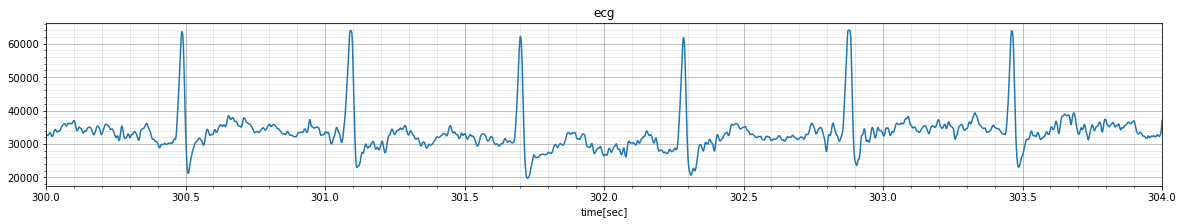

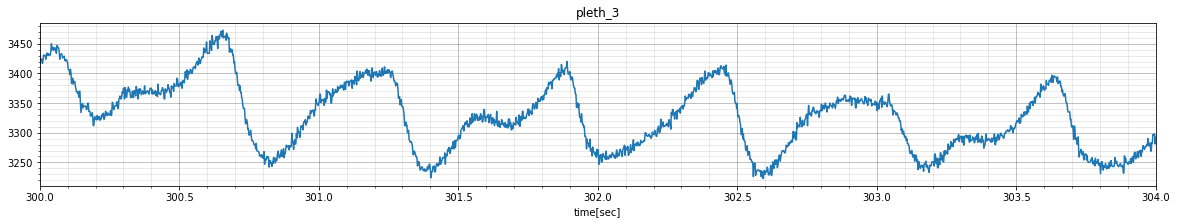

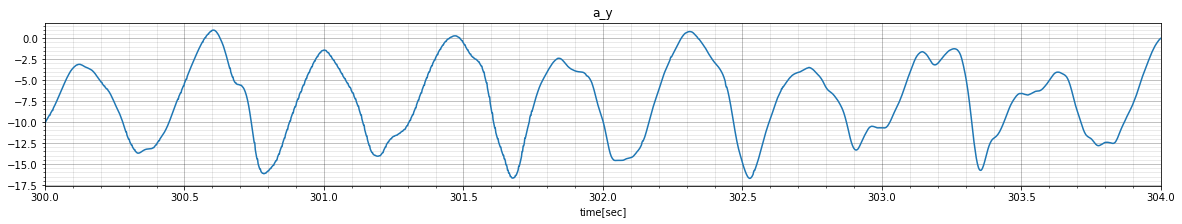

In [4]:
display_signal(t_inicial=300,signal="ecg")
display_signal(t_inicial=300,signal="pleth_3")
display_signal(t_inicial=300,signal="a_y")

<p style="font-size: 40px;
text-align:center;
font-family: 'Times New Roman';
font-variant: small-caps;
font-weight: italic;
line-height: 50px;">Correlacion Cruzada para dos señales distintas </p>
<br>

<p style="font-size: 30px;
text-align:center;
font-family: 'Times New Roman';
font-variant: small-caps;
font-weight: italic;
line-height: 50px;">Caso de ejemplo considerando 3 segundos de la señal</p>
<br>

Se inicial tomando 3 segundos de las señales "x" y "y", luego se les resta el valor promedio de la señal, y se grafican los resultados

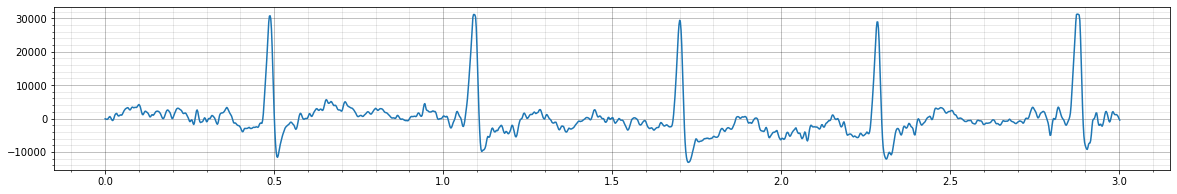

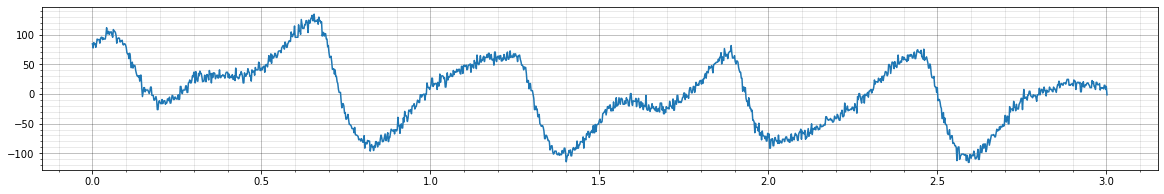

In [6]:
Ts=0.002
win_len=int(3/Ts)
n=int(300/Ts)
df=get_data(subject="s10",activity="run")
x=df.loc[n:n+win_len+1,"ecg"].to_numpy()
y=df.loc[n:n+win_len+1,"pleth_3"].to_numpy()


x=x-np.mean(x)
y=y-np.mean(y)



n=np.arange(len(x))*Ts
plot_signal(n,x)
plot_signal(n,y)

Se procede a calcular el valor de la correlación entre las señales, normalizando dicho resultado con el valor promedio geométrico de las energías de ambas señales

In [10]:
def get_corr(x,y):
    x=x-np.mean(x)
    y=y-np.mean(y)

    rxy = np.correlate(x, y, 'full')
    rxy = rxy/geometric_energy_mean(x,y)
    return rxy

def get_energy(x):
    return np.sum(x**2)

def geometric_energy_mean(x,y):
    ex=get_energy(x)
    ey=get_energy(y)
    return np.sqrt(ex*ey)
rxy=get_corr(x,y)
#rxy

Se procede a graficar el resultado obtenido

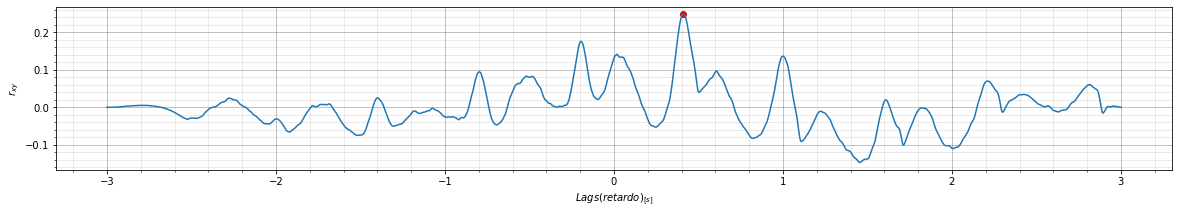

In [12]:
lag_samples=(np.arange(len(rxy)) - (len(rxy)-1)/2 ) # Desplazamiento para centrar el retraso 0
lag_seconds=lag_samples*0.002
plot_signal(x=lag_seconds,y=rxy)
plt.scatter(0.41,0.248122,c="r")
plt.ylabel("$r_{xy}$")
plt.xlabel("$Lags (retardo)_{[s]}$")
plt.plot();

El valor obtenido de 0.41 [sec] representa un adelanto de la señal $ECG$ respecto a la señal $Pleth_3$. Este valor de retardo ayuda a explicar el fenómeno físico, dado que caracteriza alguna de las dinámicas del paciente. En este caso se describe el retraso de la señal propagada desde el pulso cardiaco, hasta que se ve reflejado como un pulso en la presión sanguínea.

<p style="font-size: 30px;
text-align:center;
font-family: 'Times New Roman';
font-variant: small-caps;
font-weight: italic;
line-height: 50px;">Correlacion cruzada absoluta para dos señales distintas </p>
<br>

In [17]:
Ts=0.002

df=get_data(subject="s10",activity="run")
x=df.loc[:,"ecg"].to_numpy()
y=df.loc[:,"pleth_3"].to_numpy()


x=x-np.mean(x)
y=y-np.mean(y)


def get_corr(x,y):
    x=x-np.mean(x)
    y=y-np.mean(y)    

    rxy = np.correlate(x, y, 'full')
    rxy = rxy/geometric_energy_mean(x,y)
    return rxy

def get_energy(x):
    return np.sum(x**2)

def geometric_energy_mean(x,y):
    ex=get_energy(x)
    ey=get_energy(y)
#     print(ex)
    return np.sqrt(ex*ey)
rxy=get_corr(x,y)
#rxy

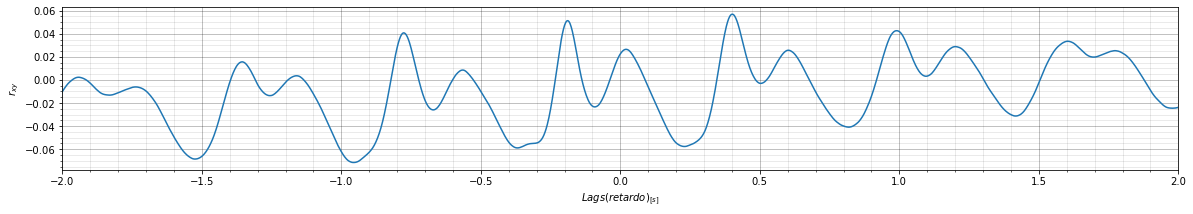

In [18]:
lag_samples=(np.arange(len(rxy)) - (len(rxy)-1)/2 ) # Desplazamiento para centrar el retraso 0
lag_seconds=lag_samples*0.002
plot_signal(x=lag_seconds,y=rxy)
plt.ylabel("$r_{xy}$")
plt.xlabel("$Lags (retardo)_{[s]}$")
plt.xlim([-2,2])
plt.plot();

<p style="font-size: 30px;
text-align:center;
font-family: 'Times New Roman';
font-variant: small-caps;
font-weight: italic;
line-height: 50px;">Correlacion cruzada en tiempo real para dos señales distintas (por medio de enventanado)</p>
<br>

<h1> Solución </h1>
    <h2>A) Selección del tamaño de la ventana de tiempo </h2>
    
    Dado que se está trabajando con una señal que proviene de un electrocardiograma, se sabe que la frecuencia máxima de una persona saludable está dada por 220[ppm]-(edad_de_la_persona), en este caso de los datos obtenidos la persona más joven del experimento tiene 20 años de edad, por consiguiente se considerará una frecuencia máxima de 200ppm, esto siginifica que en el peor escenario (para personas saludables) se espera tener un periodo mínimo de la señal de:
$$
  T_{s min} = \frac{60}{200 [ppm]}= 0.3 [seconds] 
$$

    Ahora bien para la frecuencia cardiaca mínima de las personas será del 30% del valor saludable que es de 60ppm, es decir, la mínima frecuencia cardiaca esperable será de 20ppm, por ende el valor máximo del periodo de la señal esperado será de:

$$
  T_{s max} = \frac{60}{20 [ppm]}= 3 [seconds] 
$$



In [19]:
def get_Ts_from_ppm(ppm):
    return 60/ppm
get_Ts_from_ppm(ppm=200),get_Ts_from_ppm(ppm=20)

(0.3, 3.0)


    Se puede seleccionar un valor de n veces el periodo máximo esperable de la señal. El valor médico recomendable es tomar la medida durante 15 [sec] para tener un valor confiable de la señal, con lo cual se garantiza que en el peor caso se tienen 5 oscilaciones de la señal ECG para realizar la estimación de frecuencia cardiaca. Dado que el periodo de muestreo de la señal es de 0.002 [sec] (Fs = 500 [Hz]) se sabe que 15 segundos de la señal corresponde a un total de 7500 muestras. 

<h2>B) Selección del solapamiento de la ventana de tiempo </h2>


Se selecciona un solapamiento de 1 oscilación de la señal en el peor escenario posible, es decir, de 3 [sec].

<h2>C) Cálculo de la autocorrelación </h2>

<h2>E) Convertir el dato de periodo en frecuencia </h2>

In [20]:
from scipy.signal import find_peaks
def get_T_x(subject,x_signal="ecg",y_signal="pleth_3"):
    
    df=get_data(subject=subject)
    Ts=0.002
    n=0
    win_len=int(15/Ts)
    win_sol=int(3/Ts)
    n_iter= int((len(df)-win_len)*(1/win_sol)-1)
    
    t=np.arange(0,len(df)+1)*Ts
    
    T_x_list=[]
    t_list=[]
    for _ in range(n_iter):
        x=df.loc[n:n+win_len-1,x_signal]
        y=df.loc[n:n+win_len-1,y_signal]

        rxy=get_corr(x,y)
        
        
        lag_samples=(np.arange(len(rxy)) - (len(rxy)-1)/2 ) # Desplazamiento para centrar el retraso 0
        lag_seconds=lag_samples*0.002

        lag_sample_peaks_sorted_by_rxy=find_lag_sample_peaks_sorted_by_rxy(rxy)

        T_x=abs(lag_seconds[lag_sample_peaks_sorted_by_rxy[1]])



        T_x_list.append(T_x)
        t_list.append(t[n])
        n+=win_sol
        
        
    return t_list,T_x_list

def main_plot_T_x(subject):
    
    t,T_x=get_T_x(subject)
    plot_signal(t,T_x)

    
def find_lag_sample_peaks_sorted_by_rxy(rxx):
    
    lag_sample_peaks, _  = find_peaks(rxx)

    rxx_height_map = {l_n:y for l_n,y in zip(lag_sample_peaks,rxx[lag_sample_peaks])}

    lag_sample_peaks_sorted_by_rxx=sorted(lag_sample_peaks,key=lambda x: rxx_height_map[x], reverse=True)

    return lag_sample_peaks_sorted_by_rxx

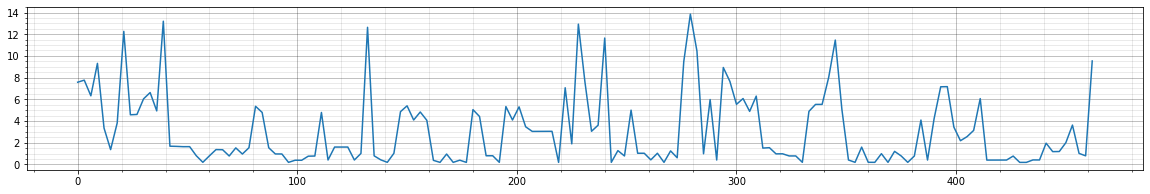

In [21]:
main_plot_T_x(subject="s10")

# Referencias 

<br>
<div style="text-align: justify;width:90%;margin: 0 auto"> 
[1]. Mehrgardt, P., Khushi, M., Poon, S., & Withana, A. (2022). Pulse Transit Time PPG Dataset (version 1.1.0). PhysioNet. https://doi.org/10.13026/jpan-6n92. <br><br>
[2] Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.. <br><br>

</div>